<a href="https://colab.research.google.com/github/elinaoik/multilabel-image-classification/blob/main/multilabel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel object classification on PASCAL VOC-2009 dataset


##I. Introduction and Set up for Classification

In this project we are going to do object classification on the PASCAL VOC-2009 dataset. The images contain objects of 20 different classes and it is very common that an image contains objects of multiple classes that our classifier is asked to identify. Therefore, it is a multilabel image classification problem. 


To begin with, we load the data and get some insights on the dataset. We visualize some examples of images with different classes and images with more than one class. From the class distribution we see that the dataset is highly unbalanced, as all classes except 'person' appear in very few images. Then we preprocess our data, by normalizing the images and getting the multi-hot encoded labels. To avoid overfitting, we are also going to do image augmentation. We use our own custom split of the dataset into train, validation and test set.


In the second part, we are building and training a model from scratch. We use a basic architecture with 3 convolutional blocks, batch normalization to speed up training and the dropout technique to avoid overfitting. For the multilabel classification problem, we use sigmoid activation functions in the last classification layer and the binary crossentropy loss function, since we want to treat each class label as its own probability distribution. After training, we evaluate the performance of our model on the test set and visualize the results. To improve the performance of our model, we implement hyperparameter tuning, in order to obtain the optimal values for several parameters of the model. We also try adversarial training.


Next, we are using the power of transfer learning to solve the same problem. We are going to use two different architectures, VGG16 and Xception, with their pre-trained weights on the same dataset (ImageNet). We expect much faster training times compared to the from-scratch model and superior performance, as those models have been trained on millions of images in the wild.


Finally, we are going to use adversarial noise in order to trick our classifier into mistakenly classify airplanes into cats. We choose to trick the VGG16 classifier, excluding the batch normalization and dropout layers, as Keras gives some difficulties when freezing those layers, causing performance problems. Then we build the adversarial model that generates the noise, using MobileNetV2 for the encoder and ImageNet weights. For training, we combine the adversarial encoder and the classifier with the frozen weights, and focues only the two labels 'aeroplane' and 'cat'. The outputs of the combined model are images of airplanes with generated noise that are classified as cats by the classifier. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Prerequisites

In [ ]:
!pip install untangle  # used to parse the annotation files
!pip install livelossplot  # used to plot the learning curves live (while learning)
!pip install hyperas # used to tune the hyperparameters
!pip install hyperopt
#!pip install git+https://github.com/maxpumperla/hyperas.git@master --upgrade
!pip install segmentation-models
!pip install --quiet neural-structured-learning

  Created wheel for untangle: filename=untangle-1.1.1-cp36-none-any.whl size=3412 sha256=15d6e9c73f6977eeb5952a82447bb77168df925ae6629ef5c79f9248a685da71
  Stored in directory: /root/.cache/pip/wheels/16/18/ff/b217dc66c822e07c274599310ba25ffce62cda02fc1c0bdca2
Successfully built untangle
     |████████████████████████████████| 112kB 2.8MB/s 


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import untangle
from livelossplot import PlotLossesKeras
from google.colab.patches import cv2_imshow
import urllib.request

import numpy as np
from numpy import *
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.metrics import average_precision_score

import tensorflow as tf
import keras
from keras import backend as K
from keras import utils, regularizers
from keras.applications import VGG16
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Convolution2D, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation, BatchNormalization, GlobalAveragePooling2D, Add, ActivityRegularization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils.conv_utils import convert_kernel
from keras.metrics import Precision, Recall
from keras.callbacks import ModelCheckpoint

import neural_structured_learning as nsl

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice

import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
weights_folder = os.path.join("drive", "My Drive", "CVWeights")
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)

### Retrieving, loading and analyzing the data set

We first need to download the PASCAL VOC (2009) dataset. Because the official servers are not always perfectly reliable, we might also use a mirror. Although the test data is available (e.g. from https://s3.amazonaws.com/scikit-data/pascal/VOC2009test.tar), of the 6925 test images, only 269 are annotated. So the test data is not very useful for us.

In [ ]:
code = -1
try:
    code = urllib.request.urlopen("http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar", timeout=3).getcode()
except Exception:  # should be urllib.error.URLError, but this does not always work
    print("Cannot retrieve data from http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar")
finally:
    if code == 200: # site is up
        !wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
    else:
        print("Retrieving data from http://doc.ml.tu-berlin.de/layerwise_relevance_propagation/VOCtrainval_11-May-2009.tar")
        !wget -nc http://doc.ml.tu-berlin.de/layerwise_relevance_propagation/VOCtrainval_11-May-2009.tar

!tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"

--2020-06-01 11:13:17--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  6.82MB/s    in 79s     

2020-06-01 11:14:37 (11.2 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 337MiB/s)


Next, we extract the images' metadata from the annotations .xml files. We will delay loading the images themselves. The reason why we sort the list afterwards is that otherwise the order seems randomized (due to the workings of os.listdir). In this way at least our base list (and say its 10th image) will always remain the same.

In [ ]:
class ImageData:

    def __init__(self, xml):
        self.filename = xml.annotation.filename.cdata
        self.folder = xml.annotation.folder.cdata
        self.width = xml.annotation.size.width.cdata
        self.height = xml.annotation.size.height.cdata
        self.depth = xml.annotation.size.depth.cdata

        self.pixels_cached = False
        self.pixels = None  # don't call this directly, use get_pixels()

        if isinstance(xml.annotation.object, list):
            self.objects = [obj.name.cdata for obj in xml.annotation.object]
        else:  # if there is only one object in the image
            self.objects = [xml.annotation.object.name.cdata]

    def get_filename_without_extension(self):
        return self.filename[:-4]  # as the filename ends with .jpg

    def get_pixels(self, cache=False):
        if self.pixels_cached:
            return self.pixels
        else:
            pixels = cv2.imread(os.path.join(voc_root_folder, "JPEGImages", self.filename))
            if cache:
                self.pixels_cached = True
                self.pixels = pixels
            return pixels

    def get_objects(self):
        return self.objects

    def get_unique_objects(self):
        return list(set(self.objects))
        

imgs_data = []
annotation_files_folder = os.path.join(voc_root_folder, "Annotations")
annotation_files = os.listdir(annotation_files_folder)
for filename in annotation_files:
    with open(os.path.join(annotation_files_folder, filename), "rb") as file:
        xml = untangle.parse(file)
        imgs_data.append(ImageData(xml))

imgs_data.sort(key=(lambda img_data: img_data.get_filename_without_extension()))

Let's show some of the images with their (first) label.

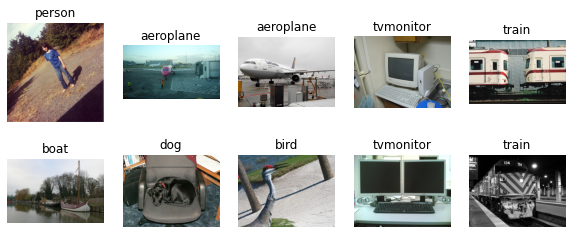

In [ ]:
fig=plt.figure(figsize=(10, 4))
columns = 5
rows = 2

for i in range(columns * rows):
    img_data = imgs_data[i]
    img = cv2.cvtColor(img_data.get_pixels(), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
    plt.title(img_data.objects[0])
    plt.axis('off')
    
plt.show()

Many images contain multiple objects. Below we get a list of all images with multiple labels.

In [ ]:
imgs_data_multiple_labels = [img_data for img_data in imgs_data if len(img_data.objects) > 1]
imgs_data_multiple_labels_iter = iter(imgs_data_multiple_labels)

print("{0:.2f}% of images have multiple labels.".format(100 * len(imgs_data_multiple_labels) / len(imgs_data)))

58.20% of images have multiple labels.


Running the cell below will show the next image with multiple labels. You can run it multiple times to get different results.

In [ ]:
def list_of_strings_to_string(list_of_strings):
    if not list_of_strings:
        return ""
    s = ""
    for i in range(len(list_of_strings) - 1):
        s += list_of_strings[i] + ", "
    s += list_of_strings[-1]
    return s

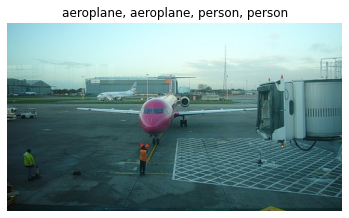

In [ ]:
img_data = next(imgs_data_multiple_labels_iter)
img = cv2.cvtColor(img_data.get_pixels(), cv2.COLOR_BGR2RGB)
plt.imshow(img)
    
object_names = img_data.objects
plt.title(list_of_strings_to_string(object_names))

plt.axis('off')
    
plt.show()

In total there are 20 different classes, listed below.

In [ ]:
class_names = []
for img_data in imgs_data:
    for object_name in img_data.objects:
        if not object_name in class_names:
            class_names.append(object_name)
print(class_names)
nb_classes = len(class_names)
print(nb_classes)

['person', 'aeroplane', 'tvmonitor', 'train', 'boat', 'dog', 'chair', 'bird', 'bicycle', 'bottle', 'sheep', 'diningtable', 'horse', 'motorbike', 'sofa', 'cow', 'car', 'cat', 'bus', 'pottedplant']
20


Let's also see how the classes are distributed.

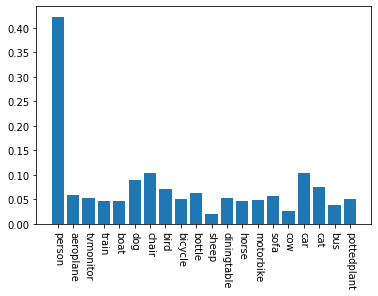

The baseline accuracy to beat is 92.38%.


In [ ]:
class_counts = {class_names[i]: 0 for i in range(len(class_names))}
for img_data in imgs_data:
    for class_name in img_data.get_unique_objects(): # avoid double counting
        class_counts[class_name] += 1

# Make a histogram (as a bar chart)
rel_class_counts_list = [class_counts[class_name] / len(imgs_data) for class_name in class_counts]
plt.bar(list(range(nb_classes)), height=rel_class_counts_list)
plt.xticks(list(range(nb_classes)), class_names, rotation=-90)
plt.show()

print("The baseline accuracy to beat is {:.2f}%.".format((1 - np.mean(rel_class_counts_list)) * 100))

We see that 'person' is by far the most common class. This seemingly makes the data unbalanced. But because we want to do multilabel classification, we actually make 20 binary decisions per image, e.g. does this image contain a cow? This means that the data is indeed very unbalanced, but actually not because of the dominance of 'person', but because most of the time we will predict a binary 'no'. In fact, 'person' is the most balanced class in this respect. 

As a consequence the accuracy of a majority predictor will already be $92.38\%$, being the mean over the classes of the accuracy of a majority predictor for one particular class. This also shows that accuracy is not a very relevant metric. Precision per class will be more useful. In fact, in the [devkit documentation](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/devkit_doc_14-May-2009.pdf) we can read that "The classification task will be judged by the precision/recall curve. The principal quantitative measure used will be the average precision (AP)."

### Normalizing and augmenting the data

We need to normalize our data. Firstly, we want to work with floats between 0 and 1 instead of integers (between 0 and 255). Secondly, not all images have the same size. To make matters worse, if we do not downscale our images we cannot fit all data as 32-bit floats into RAM.

In [ ]:
img_size = 128
def normalize_image(image):
    return np.array(cv2.resize(image, (img_size, img_size))).astype("float32") / 255.0

Our input data will then simply consist of a (numpy) array of such normalized images. Since our outputs are categorical, we will first need to convert them using one-hot encoding, or rather multi-hot encoding as we are tackling a multilabel classification problem. We will use scikit-learn's MultiLabelBinarizer. Note that we simply want to predict for every of the 20 classes if the image contains it. We do not care about the precise counts (e.g. we won't output that an image contains three sheep, just that it contains at least one).

In [ ]:
X = np.array([normalize_image(img_data.get_pixels()) for img_data in imgs_data])

y_labels = [img_data.get_objects() for img_data in imgs_data]  # (or get_unique_objects())
encoder = MultiLabelBinarizer()
y = encoder.fit_transform(y_labels)

# loop over each of the possible class labels and show them
print('Encoded classes:')
for (i, label) in enumerate(encoder.classes_):
	print("{}. {}".format(i + 1, label))

print('')
print('Example: encoding of multiclass label (\'bird\', \'cat\', \'sofa\')')
print(encoder.transform([('bird', 'cat', 'sofa')]))

print('')
print('Example: encoding of multiclass label (\'person\', \'horse\', \'person\')')
print(encoder.transform([('person', 'horse', 'person')]))

Encoded classes:
1. aeroplane
2. bicycle
3. bird
4. boat
5. bottle
6. bus
7. car
8. cat
9. chair
10. cow
11. diningtable
12. dog
13. horse
14. motorbike
15. person
16. pottedplant
17. sheep
18. sofa
19. train
20. tvmonitor

Example: encoding of multiclass label ('bird', 'cat', 'sofa')
[[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]]

Example: encoding of multiclass label ('person', 'horse', 'person')
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]]


In [ ]:
def get_index_of_object(object_name):
    return np.argmax(encoder.transform([[object_name]])[0])  # transform works on lists of lists of object names and outputs a list of multi-hot coded vectors

We divide our normalized data into a training set (70%) a validation set (15%) and a test set (15%). An official split is provided, but this only gives a train/validation divide, and furthermore only uses 7054 of the 7818 images.

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=3/17, random_state=42)  # 3/17 of 85% is 15%
print("Number of training examples: {}".format(len(y_train)))
print("Number of validation examples: {}".format(len(y_val)))
print("Number of test examples: {}".format(len(y_test)))

Number of training examples: 5472
Number of validation examples: 1173
Number of test examples: 1173


In order to avoid overfitting and to train on more data, we apply data augmentation in our training set. We are going to apply several transformation on the images, such as a rescale, rotation, width/height shift, zoom and horizontal flip.

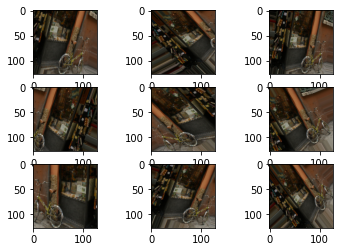

In [ ]:
# Create image data augmentation generator
datagen = ImageDataGenerator(
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    shear_range=0.2,
                    zoom_range=0.3,
                    fill_mode="nearest"
                    )

# Visualize the data Augmentation in an image from the train set
img_sample = X_train[100]
img = array_to_img(img_sample)
data = img_to_array(img)
samples = np.expand_dims(data, 0) # expand dimension to one sample
it = datagen.flow(samples, batch_size=1) # prepare iterator
for i in range(9): # generate samples and plot
    plt.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers for viewing
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB for viewing
    plt.imshow(image) # plot raw pixel data
# show the figure
plt.show()

##II. ConvNet for Image Classification

### Compile the model
We build a model with 3 convolutional blocks. 

Below we describe the architectural decisions for our ConvNet:

- Each convolutional block has 2 convolutional layers with progressively increasing number of filters, with as purpose to capture basic features in the first blocks, such as lines and edges, and more higher-level features in the last blocks, representative of each class. 

- **ReLU activation function**: after each Conv2D layer we use the ReLU function, given by the formula R(x) = max(0,x). It is powerful for training deep neural network architectures as it can capture non-linear features, while avoiding the vanishing gradient problem. Leaky ReLU, a modification of the original function, fixes the problem of dying neurons. Note that we can use ReLU only in the internal layers of our model.

- **[Batch Normalization](https://www.machinecurve.com/index.php/2020/01/15/how-to-use-batch-normalization-with-keras/#)**: while training after each Conv2D layer the output values change, which means the distribution of input data of each layer changes, which can slow down training. Batch normalization ensures that the distribution of the input data remains similar over time by normalizing, scaling and shifting it.

- **MaxPooling2D**: this downsamples its input feature representation, by keeping the maximum value of non-overlapping regions with stride 2x2.

- **Dropout**: In order to avoid overfitting, we use dropout. It prevents a layer from seeing the exact same pattern twice, acting in a way analoguous to data augmentation, another methodology used to avoid overfittting. In essense dropout tends to disrupt random correlations occuring in our data. How dropout works: while training, dropout drops a neuron with a probability p and sets it to zero.

**Fully connected layers**

- **Flatten layer**: it transforms the features into an 1-dimensional array. 

- **Dense layer**: it represents a matrix vector multiplication and in practice changes the dimension of the flattten layer to a new smaller one. We use two dense layers of size 1x1024 and a third one of size 1x20, which represents the 20 classes. We can also apply batch normalization and dropout between the dense layers.

- **Sigmoid activation function**: after the last dense layer we use the sigmoid function which is appropriate for a multi-label classification task. It will output probabilities of each class in the range [0,1].

**Compiling the model**

- **Binary Cross-Entropy Loss**: we choose this over categorical cross-entropy, as we want to [treat the probabilities of each class as an individual distribution and penalize each output node individually](https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/).

- **[Metrics](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)**: we know that accuracy is not the most suitable metric for multilabel classification, therefore we include precision and recall, which is what we really want to optimize during training.

In [ ]:
def create_model_architecture():

    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), name='Conv2D_1.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(32, (3, 3), activation='relu', name='Conv2D_1.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_1'))
    model.add(Dropout(0.26, name='Dropout_1'))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', name='Conv2D_2.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(64, (3, 3), activation='relu', name='Conv2D_2.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_2'))
    model.add(Dropout(0.26, name='Dropout_2'))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', name='Conv2D_3.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (3, 3), activation='relu', name='Conv2D_3.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_3'))
    model.add(Dropout(0.26, name='Dropout_3'))

    '''# Fourth convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', name='Conv2D_4.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (3, 3), activation='relu', name='Conv2D_4.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_4'))
    model.add(Dropout(0.25, name='Dropout_4'))'''

    # Fully connected layer and classifier
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(256, activation='relu')) #256
    model.add(BatchNormalization())
    model.add(Dropout(0.48))
    model.add(Dense(256, activation='relu')) #64
    model.add(BatchNormalization())
    model.add(Dense(20, activation='sigmoid'))

    return model

# Create model architecture
model = create_model_architecture()

# Compile the model: set loss function, optimizer and optimization metric
model.compile(loss='binary_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'), 
                       tf.keras.metrics.Recall(name='Recall')])

# Print model architecture summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1.1 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
Conv2D_1.2 (Conv2D)          (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 124, 124, 32)      128       
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 62, 62, 32)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
Conv2D_2.1 (Conv2D)          (None, 60, 60, 64)       

### Train & evaluate the model
We set the batch size to 64 and the number of epochs to 150.
We define 3 callbacks:
- Early Stopping: training will stop if the validation loss is not decreasing by 0.5% for a defined number of epochs. This is another technique to avoid overfitting. In addition it reduces the computational load by (as the name indicates) stopping earlier.
- Model Checkpoint: the weights of the models with the best validation loss.
- Plot Losses Keras: we get a live visualization of the loss during training and the metrics we defined during the model compilation (accuracy, precision, recall).

After training, we are going to evaluate the model on the test set.

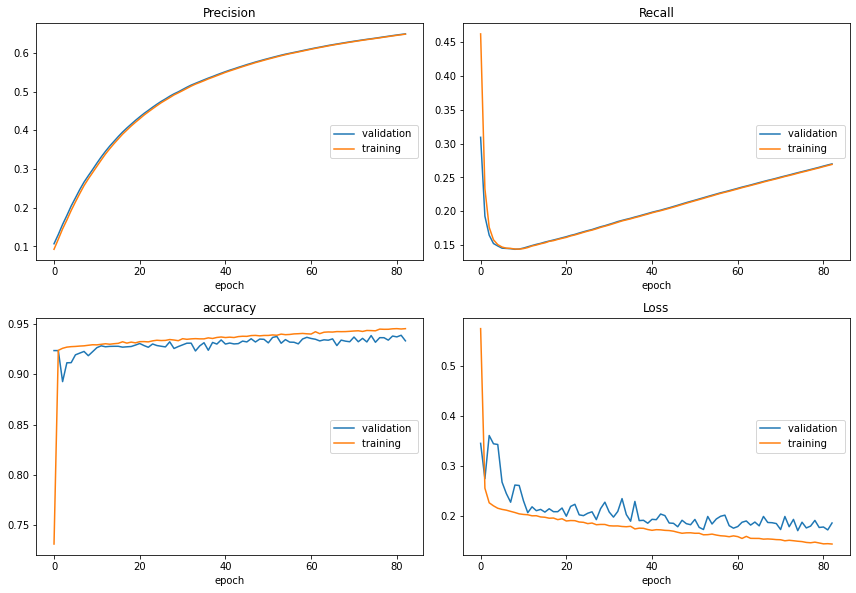

Precision
	validation       	 (min:    0.107, max:    0.649, cur:    0.649)
	training         	 (min:    0.093, max:    0.648, cur:    0.648)
Recall
	validation       	 (min:    0.144, max:    0.309, cur:    0.270)
	training         	 (min:    0.144, max:    0.462, cur:    0.269)
accuracy
	validation       	 (min:    0.893, max:    0.939, cur:    0.933)
	training         	 (min:    0.731, max:    0.945, cur:    0.945)
Loss
	validation       	 (min:    0.171, max:    0.361, cur:    0.186)
	training         	 (min:    0.144, max:    0.574, cur:    0.144)

Performance Metrics on Test Set
Accuracy:      93.27%
Loss:          0.189
Precision:     64.90%
Recall:        27.01%


In [ ]:
# Set parameters for training
batch_size = 64
epochs = 150

# Define callbacks
my_callbacks = [

  # Define Early Stopping Callback
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=epochs//5, mode='min'),

  # Save best weights
  keras.callbacks.ModelCheckpoint(filepath='convnet.{epoch:02d}-{val_loss:.3f}.h5', verbose=1,
                                              save_best_only=True, monitor='val_loss', mode='min'),
  # Live Plotting during training              
  PlotLossesKeras(),
]

# We use the fit_generator method to train the model with real time data augmentation
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=my_callbacks, verbose=1, validation_data=(X_val, y_val))

# Evaluate on the test set
test_loss, test_acc, test_prec, test_recall = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc*100))
print('Loss:          {:.3f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec*100))
print('Recall:        {:.2f}%'.format(test_recall*100))

After training, we load the weights of the epoch with the lowest validation error. In our case, this was epoch 87 with validation loss 0.164 .

In [ ]:
# Save the model and the trained weights
#model.save_weights("classification_model_weights.h5")
model.save('convnet_model.h5')

# Reload the best model weights with the lowest loss 
#model = load_model('convnet_model.h5')
model.load_weights('convnet.87-0.164.h5')

We print out again the evaluation metrics on the test set, using the best weights. We notice that the results are better compared to the last weights. The obtained accuracy is 94.01%, so higher than the base accuracy. The loss is 0.168.

In [ ]:
# Evaluate on the test set
test_loss, test_acc, test_prec, test_recall = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc*100))
print('Loss:          {:.3f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec*100))
print('Recall:        {:.2f}%'.format(test_recall*100))


Performance Metrics on Test Set
Accuracy:      94.01%
Loss:          0.168
Precision:     67.64%
Recall:        39.04%


In [ ]:
# Print out the classification metrics per class for Training data
preds = np.round(model.predict(X_train), 0)
classification_metrics = metrics.classification_report(y_train, preds, target_names=encoder.classes_)
print(classification_metrics)

              precision    recall  f1-score   support

   aeroplane       0.90      0.76      0.82       321
     bicycle       0.88      0.34      0.49       273
        bird       0.85      0.47      0.60       385
        boat       0.69      0.69      0.69       239
      bottle       0.86      0.05      0.10       340
         bus       0.84      0.62      0.71       217
         car       0.74      0.41      0.53       573
         cat       0.74      0.60      0.66       402
       chair       0.63      0.42      0.51       563
         cow       0.72      0.35      0.47       145
 diningtable       0.61      0.45      0.51       285
         dog       0.74      0.22      0.33       492
       horse       0.79      0.48      0.60       264
   motorbike       0.85      0.56      0.67       271
      person       0.90      0.73      0.80      2330
 pottedplant       0.70      0.27      0.39       277
       sheep       0.66      0.37      0.48       107
        sofa       0.73    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print out the classification metrics per class for Test data
preds = np.round(model.predict(X_test), 0)
classification_metrics = metrics.classification_report(y_test, preds, target_names=encoder.classes_)
print(classification_metrics)
print('')

# Print mean Average Precision score
print("mAP: {:.2f}%".format(average_precision_score(y_test, preds) * 100))

              precision    recall  f1-score   support

   aeroplane       0.88      0.58      0.69        73
     bicycle       0.73      0.12      0.21        65
        bird       0.61      0.29      0.39        80
        boat       0.50      0.56      0.53        57
      bottle       0.00      0.00      0.00        77
         bus       0.71      0.53      0.61        47
         car       0.53      0.31      0.39       121
         cat       0.62      0.41      0.50        92
       chair       0.54      0.31      0.39       124
         cow       0.36      0.17      0.23        29
 diningtable       0.42      0.23      0.30        57
         dog       0.43      0.11      0.17        94
       horse       0.50      0.16      0.24        44
   motorbike       0.74      0.49      0.59        59
      person       0.81      0.67      0.73       498
 pottedplant       0.50      0.16      0.24        63
       sheep       0.43      0.12      0.18        26
        sofa       0.58    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The code below allows us to visualize the predictions. The third cell can be run repeatedly.

In [ ]:
random_indices = list(range(len(X_test)))
random.shuffle(random_indices)
random_indices_iter = iter(random_indices)

In [ ]:
def y_preds_to_list_of_labels_with_confidence(y_preds):
    y_preds_bin = np.round(y_preds, 0)
    y_pred_labels = encoder.inverse_transform(y_preds_bin)

    y_pred_labels_with_conf = []
    for j in range(len(y_pred_labels)):
        img_labels = y_pred_labels[j]
        img_labels_with_conf = []
        for label in img_labels:
            img_labels_with_conf.append(label + " ({:.2f})".format(y_preds[j][get_index_of_object(label)]))
        y_pred_labels_with_conf.append(img_labels_with_conf)
    
    return y_pred_labels_with_conf

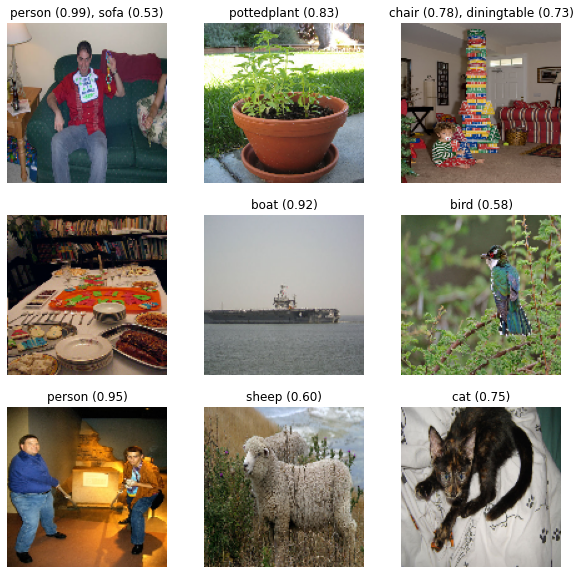

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

next_is = []  # (the 's' is for plural)
for j in range(columns * rows):
    next_is.append(next(random_indices_iter))

xs = []
for i in next_is:
    xs.append(X_test[i])

y_preds = model.predict(np.array(xs))
y_preds_labels_conf = y_preds_to_list_of_labels_with_confidence(y_preds)

for j in range(columns * rows):
    img = cv2.cvtColor(xs[j], cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(img)
    plt.title(list_of_strings_to_string(y_preds_labels_conf[j]))
    plt.axis('off')
    
plt.show()

###Hyperparameter Tuning
In order to improve the performance of the model, we want to do [hyperparameter tuning](https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/). There are several strategies to approach this, such as: manual tuning, grid search, random search and a Bayesian approach.

- **Manual Tuning**: this approach might be fun in the beginning, however it is not scalable and requires lots of time and human attention. Moreover, in the case of deep learning, this method cannot guarantee optimal results, as the number of hyperparameters to tune is very large to handle.

- **Grid Search**: despite the fact that this method is very popular in machine learning, it cannot handle efficiently deep learning cases due to the large number of hyperparameters. It could guarantee the best solution, but with a very high cost.

- **Random search**: this method performs better in high dimensional spaces and yields better results w.r.t. gridsearch in fewer iterations. However, it doesn't guarantee to find the best hyperparameters.

- **Bayesian Optimization**: this strategy builds a model that tries to predict which hyperparameters matter the most for increasing the performance of our model. At each iteration, it becomes more and more confident about which new guesses will lead to improvements. It is suitable for high-dimensional cases, hence deep learning models, and it has lower cost that other methods.

The approach that we follow is the Bayesian one. It falls under the class of algorithms called Sequential Model Based Optimization (SMBO). 

In practice, we are going to use the hyperopt and [hyperas](https://github.com/maxpumperla/hyperas) framework, as showcased by Max Pumperla. 


In order to implement and execute this wrapper, we need to define a data function and a create_model function.
In the model function, we are going to do all the preprocessing steps as before. In the create_model function, we again define our model architecture, with the hidden layers, the fully connected layers and the classifier. At this point, we will explicitly mention all the parameters that we want to tune:

- Number of filter on convolutional layers
- Number of neurons in the 2 fully connected layers
- Dropout value after Conv blocks and fully connected Layer
- Batch size
- Number of convolutional blocks (3 or 4)
- Optimization function.

With the below piece of code, we will run several experiments. For some of them, we try to optimize several hyperparameters at once. This requires more evaluation runs and several hours to execute. We will also run smaller experiments, so we will fix most of the hyperparameters and tune only one or two of them. 

The results of this process are the design choices for the model architecture, as presented on the above part. We managed to improve significantly the performance of the model for all metrics. For example, test loss was improved from ~0.22 to 0.168!


In [ ]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='CV Final project - classification.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('CV Final project - classification.ipynb')

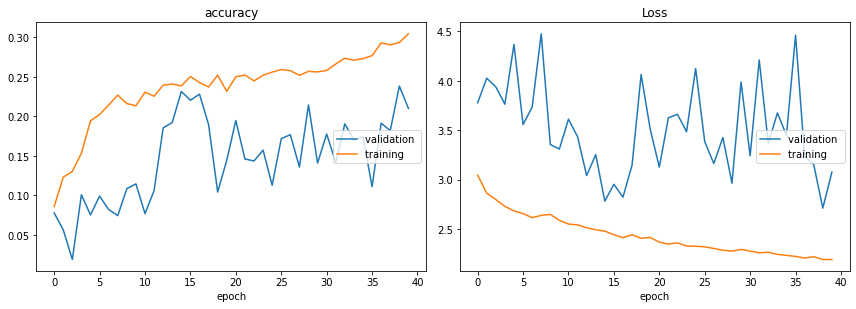

accuracy
	validation       	 (min:    0.019, max:    0.238, cur:    0.210)
	training         	 (min:    0.086, max:    0.305, cur:    0.305)
Loss
	validation       	 (min:    2.712, max:    4.476, cur:    3.076)
	training         	 (min:    2.192, max:    3.046, cur:    2.193)
Best validation acc of epoch:
0.23846153914928436
100%|██████████| 5/5 [1:44:45<00:00, 1257.14s/it, best loss: -0.39829060435295105]
Evalutation of best performing model:
1173/1173 [==============================] - 2s 2ms/step
[2.167369693136581, 0.3759590685367584]
Best performing model chosen hyper-parameters:
{'n_blocks': 0, 'n_dense1': 2, 'n_dense2': 2, 'n_filters_1': 1, 'n_filters_1_1': 0, 'n_filters_1_2': 2, 'n_filters_1_3': 1, 'optim': 3, 'p': 0.288662535902546, 'p_1': 0.3376263809413643}


In [ ]:
def data():
    '''
    Data providing function:

    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    voc_root_folder = "/content/VOCdevkit/VOC2009"

    data = []
    annotation_files_folder = os.path.join(voc_root_folder, "Annotations")
    annotation_files = os.listdir(annotation_files_folder)
    for filename in annotation_files:
        with open(os.path.join(annotation_files_folder, filename), "rb") as file:
            xml = untangle.parse(file)

        f_name = xml.annotation.filename.cdata
        image = cv2.imread(os.path.join(voc_root_folder, "JPEGImages", f_name))

        objects = []
        if isinstance(xml.annotation.object, list):  # might contain just 1 object, in which case it is not a list
            objects = [obj.name.cdata for obj in xml.annotation.object]
        else:
            objects = [xml.annotation.object.name.cdata]

        data.append({"Filename": f_name, "Image": image, "Objects": objects})

    def normalize_image(image):
        return np.array(cv2.resize(image, (128, 128))).astype("float32") / 255.0

    X = np.array([normalize_image(data_pt["Image"]) for data_pt in data])

    y_labels = [data_pt["Objects"][0] for data_pt in data]
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y_labels)

    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    return X_trainval, y_trainval, X_test, y_test


def create_model(X_train, y_train, X_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    # Define hyperparameters to tune

    # No of filters in Convolutional Layers
    n_filters_1 = {{choice([32, 64, 128])}}
    n_filters_2 = {{choice([32, 64, 128])}}
    n_filters_3 = {{choice([32, 64, 128])}}

    # No of nodes in Dense Layers
    n_dense1 = {{choice([128, 256, 512, 1024])}}
    n_dense2 = {{choice([64, 128, 256, 512])}}

    # Dropout Rate
    p = {{uniform(0,1)}}
    p1 = {{uniform(0,1)}}

    # Batch size and Optimization algorithm
    batch_size = {{choice([32, 64, 128])}}
    optim = {{choice(['adam', 'Adamax', 'SGD', 'RMSprop'])}}

    # Number of Convolutional Blocks
    n_blocks = {{choice(['three', 'four'])}}

    # -----------------------------------------------------------

    # Split train data into train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.176, random_state=42)


    ## Build the model
    model = Sequential(name='ConvNet for Image Classification')

    # First convolutional block
    model.add(Conv2D(n_filters_1, (3, 3), activation='relu', input_shape=(128, 128, 3), name='Conv2D_1.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(n_filters_1, (3, 3), activation='relu', name='Conv2D_1.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_1'))
    model.add(Dropout(p, name='Dropout_1'))

    # Second convolutional block
    model.add(Conv2D(n_filters_2, (3, 3), activation='relu', name='Conv2D_2.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(n_filters_2, (3, 3), activation='relu', name='Conv2D_2.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_2'))
    model.add(Dropout(p, name='Dropout_2'))

    # Third convolutional block
    model.add(Conv2D(n_filters_3, (3, 3), activation='relu', name='Conv2D_3.1'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(n_filters_3, (3, 3), activation='relu', name='Conv2D_3.2'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_3'))
    model.add(Dropout(p, name='Dropout_3'))

    
    # If we choose 'four', add an additional fourth layer
    if n_blocks == 'four':
        model.add(Conv2D(n_filters_3, (3, 3), activation='relu', name='Conv2D_4.1'))
        model.add(BatchNormalization(axis=-1))
        model.add(Conv2D(n_filters_3, (3, 3), activation='relu', name='Conv2D_4.2'))
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPooling_4'))
        model.add(Dropout(p, name='Dropout_4'))

    # Fully connected layer and classifier
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(1024, activation='relu')) #256
    model.add(BatchNormalization())
    model.add(Dropout(p1))
    model.add(Dense(1024, activation='relu')) #64
    model.add(BatchNormalization())
    model.add(Dense(20, activation='sigmoid'))

    # Compile the model: set loss function, optimizer and optimization metric
    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])
    
    # Create image data augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=.15,
        height_shift_range=.15,
        horizontal_flip=True,
        shear_range=0.15,
        zoom_range=0.3,
        fill_mode="nearest"
        )

    # We use the fit_generator method to train the model with real time data augmentation
    result = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=40,
                    callbacks=[PlotLossesKeras()], verbose=0, validation_data=(X_val, y_val)) 

    # Get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_accuracy']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}


if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=10,
                                          trials=Trials(),
                                          notebook_name='CV Final project - classification')
    X_train, y_train, X_test, y_test = data()
    print("Evalutation of best performing model:")
    print(best_model.evaluate(X_test, y_test))
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

###Adversarial Training

In this part, we are going to train our classification model using training data that have been augmented with adversarial noise. As we will see also later on in the IV part of this notebook, when adding some adversarial noise to an image, the classifier can be fooled, resulting in predictions of a wrong class with high confidence. This phenomenon is attributed to the linear nature of deep neural networks [[Goodfellow et al., 2015]](https://arxiv.org/pdf/1412.6572.pdf).

Adversarial examples can be used during training in order to make the classifier robust against adversarial attacks. It is an alternative form of data augmentation, where the model is trained with the original images and images with additional noise. The adversarial images look similar to the original ones to the human eye, however they are unlikely to occur naturally and they can confuse a classification model. When training the classifier using adversarial examples, the model learns that the adversarial images are actually pretty similar to the original ones, so it learns more meaningful features about each class.

Goodfellow et al. claim that this method leads to better generalization compared to other methods such as dropout. Below we are going to implement training with adversarial examples generated by the 'fast gradient sign method'. We are going to use the Tensorflow framework [Neural Structured Learning (NSL)](https://www.tensorflow.org/neural_structured_learning), which was introduced in 2019. 

The hyperparameters of the adversarial regularization are:
- adv_multiplier: The weight of adversarial loss in the training objective, relative to the labeled loss. 
- adv_step_size: The magnitude of adversarial perturbation.
- adv_grad_norm: The norm to measure the magnitude of adversarial perturbation.

In [ ]:
# Convert y labels into 'float32' type arrays
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
# Create a base model - same architecture as before 
base_model = tf.keras.Sequential([
    tf.keras.Input([img_size, img_size, 3], dtype=tf.float32, name='image'),

    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='Conv2D_1.1'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='Conv2D_1.2'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='MaxPooling_1'),
    tf.keras.layers.Dropout(0.4, name='Dropout_1'),

    # Second convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='Conv2D_2.1'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='Conv2D_2.2'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='MaxPooling_2'),
    tf.keras.layers.Dropout(0.4, name='Dropout_2'),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='Conv2D_3.1'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='Conv2D_3.2'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='MaxPooling_3'),
    tf.keras.layers.Dropout(0.4, name='Dropout_3'),

    # Fully connected layer and classifier
    tf.keras.layers.Flatten(),  # this converts our 3D feature maps to 1D feature vectors
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation='sigmoid')

])

base_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1.1 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_202 (Bat (None, 126, 126, 32)      128       
_________________________________________________________________
Conv2D_1.2 (Conv2D)          (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_203 (Bat (None, 124, 124, 32)      128       
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 62, 62, 32)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
Conv2D_2.1 (Conv2D)          (None, 60, 60, 128)     

In [ ]:
# Wrap the model with adversarial regularization. 
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.3, adv_step_size=0.2) 
adv_model = nsl.keras.AdversarialRegularization(base_model, adv_config=adv_config)

# Compile the model: set loss function, optimizer and optimization metric
adv_model.compile(loss='binary_crossentropy', optimizer='Adamax',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'), 
                           tf.keras.metrics.Recall(name='Recall')])

In [ ]:
# Set parameters for training
batch_size = 64
adv_epochs = 30

# Define callbacks
my_adv_callbacks = [

  # Define Early Stopping Callback
  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=adv_epochs//5, mode='min'),

  # Save best weights
  tf.keras.callbacks.ModelCheckpoint(filepath='adv_convnet.{epoch:02d}-{val_loss:.3f}.h5', verbose=0,
                                     save_best_only=True, monitor='val_loss', mode='min'), 
                
]

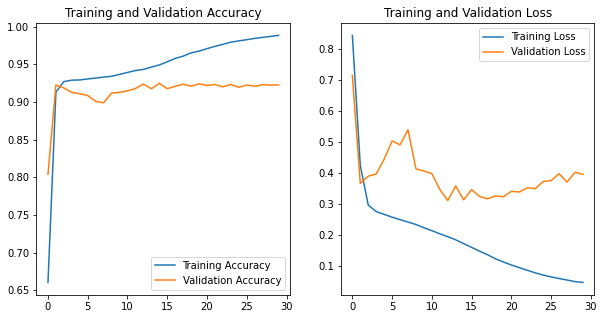

In [ ]:
# We use the fit_generator method to train the model with real time data augmentation
history = adv_model.fit({'image': X_train, 'label': y_train}, batch_size=batch_size, epochs=adv_epochs,
                        callbacks = my_adv_callbacks, verbose=0, 
                        validation_data={'image': X_val, 'label': y_val})

# Visualize Accuracy and Loss on Training and Validation set
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(adv_epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Reload the best model weights with the lowest Loss 
adv_model.load_weights('adv_convnet.13-0.311.h5')

# Evaluate on the test set
test_loss, test_crossentropy, test_acc, test_prec, test_recall, test_adv_loss = adv_model.evaluate({'image': X_test, 'label': y_test}, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc*100))
print('Loss:          {:.3f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec*100))
print('Recall:        {:.2f}%'.format(test_recall*100))
print('Adversarial Loss:  {:.2f}%'.format(test_adv_loss*100))

37/37 - 1s - loss: 0.3172 - binary_crossentropy: 0.2353 - binary_accuracy: 0.9205 - Precision: 0.4484 - Recall: 0.1544 - adversarial_loss: 0.2732

Performance Metrics on Test Set
Accuracy:      92.05%
Loss:          31.72%
Precision:     44.84%
Recall:        15.44%
Adversarial Loss:  27.32%


##III. Transfer learning

In transfer learning we make use of (parts of) pretrained deep neural networks. Since most of the learnt features in the ealier layers are very general (e.g. lines), these will also be relevant in our current task. Using transfer learning we can also implicity use more training data. 

### VGG16

In our case we will first be using VGG16 [(Simonyan and Zisserman, 2015)](https://arxiv.org/pdf/1409.1556.pdf), pretrained on ImageNet. Although not the newest architecture at this point, it is quite simple and still very performant with over [90% top 5 accuracy on ImageNet](https://keras.io/applications/#documentation-for-individual-models). 

Because ImageNet uses different classes (and more of them), we cannot just use this network as is. Instead, we will remove all fully connected classification layers (the 'top') and readd them manually, using random small weights. Since we only want to train these newly added layers in a first stage, we freeze the other proper VGG layers.

Without regularization the network was overfitting (with validation loss increasing from less than 0.2 to more than 0.6), so we added dropout layers, and also use data augmentation and early stopping. In addition, we also added batch normalization.

In [ ]:
def get_our_VGG_model(freeze_non_top):
    vgg_without_top = VGG16(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
    if freeze_non_top:
        for layer in vgg_without_top.layers:
            layer.trainable = False

    model = Sequential()
    model.add(vgg_without_top)

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(4096, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(4096, activation='relu', name='fc2'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(nb_classes, activation='sigmoid', name='prediction'))

    model.summary()
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model

We now train our network on our training data.

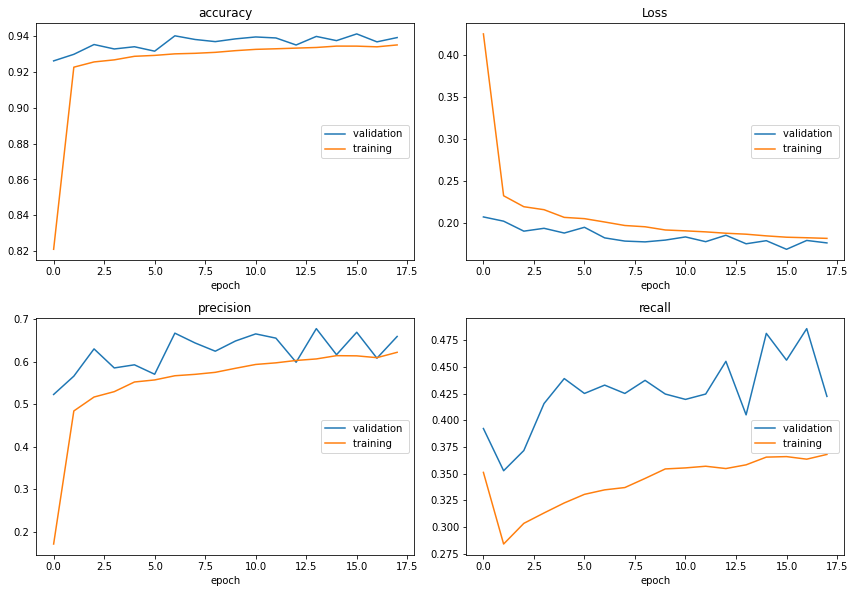

accuracy
	validation       	 (min:    0.926, max:    0.941, cur:    0.939)
	training         	 (min:    0.821, max:    0.935, cur:    0.935)
Loss
	validation       	 (min:    0.169, max:    0.207, cur:    0.176)
	training         	 (min:    0.182, max:    0.425, cur:    0.182)
precision
	validation       	 (min:    0.523, max:    0.678, cur:    0.660)
	training         	 (min:    0.171, max:    0.622, cur:    0.622)
recall
	validation       	 (min:    0.353, max:    0.486, cur:    0.422)
	training         	 (min:    0.284, max:    0.368, cur:    0.368)


In [ ]:
batch_size = 32
epochs = 50

model = get_our_VGG_model(True)

# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=epochs//5, mode='min')

model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=[PlotLossesKeras(), early_stopping], verbose=1, validation_data=(X_val, y_val))

Note that the validation performance starts off a lot better than the training performance. The reason is that dropout is only applied during training, not validation.  Before moving on to the evaluation of the model, let's save it first.

In [ ]:
model.save(os.path.join(weights_folder, "VGG.h5"))

To reload it we can use the following code. It can also be used to skip the training, at least if the weights from a previous run have already been saved. If all code is run sequentially and we have just saved the model, then obviously this code is not useful and can be skipped.

In [ ]:
model = get_our_VGG_model(True)
model.load_weights(os.path.join(weights_folder, "VGG.h5"))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 8192)              32768     
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              33558528  
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 4096)             

 Next we evaluate our model on the test set.

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc * 100))
print('Loss:          {:.2f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec * 100))
print('Recall:        {:.2f}%'.format(test_rec * 100))


Performance Metrics on Test Set
Accuracy:      93.96%
Loss:          0.18
Precision:     66.84%
Recall:        42.20%


For a more in-depth analysis we will use scikit-learn's evaluation metrics, in particular (m)AP.

In [ ]:
# Print out the classification metrics per label for Training data
preds = np.round(model.predict(X_test), 0)
classification_metrics = metrics.classification_report(y_test, preds, target_names=encoder.classes_)
print(classification_metrics)
print("")
print("mAP: {:.2f}%".format(average_precision_score(y_test, preds) * 100))

              precision    recall  f1-score   support

   aeroplane       0.94      0.42      0.58        73
     bicycle       0.46      0.38      0.42        65
        bird       0.63      0.39      0.48        80
        boat       0.54      0.49      0.51        57
      bottle       0.45      0.13      0.20        77
         bus       0.58      0.66      0.62        47
         car       0.54      0.44      0.48       121
         cat       0.69      0.46      0.55        92
       chair       0.48      0.25      0.33       124
         cow       0.36      0.31      0.33        29
 diningtable       0.57      0.23      0.32        57
         dog       0.68      0.44      0.53        94
       horse       0.69      0.20      0.32        44
   motorbike       0.64      0.27      0.38        59
      person       0.80      0.66      0.73       498
 pottedplant       0.44      0.17      0.25        63
       sheep       0.31      0.19      0.24        26
        sofa       0.43    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our mAP is very low, mainly because of the low recalls. Below we'll try to improve it.

Potentially we could increase performance further by now also allowing the training of the VGG layers. We tested this by unfreezing all layers and training for another 50 epochs (at most). But this made the model overfit heavily (with a validation loss of about 12). Therefore we added L2 regularization everywhere. A regularization constant of $10^{-3}$ was not sufficient to stop the overfitting and therefore we increased it to $10^{-1}$. A more thorough approach would be to again use hyperparameter tuning.

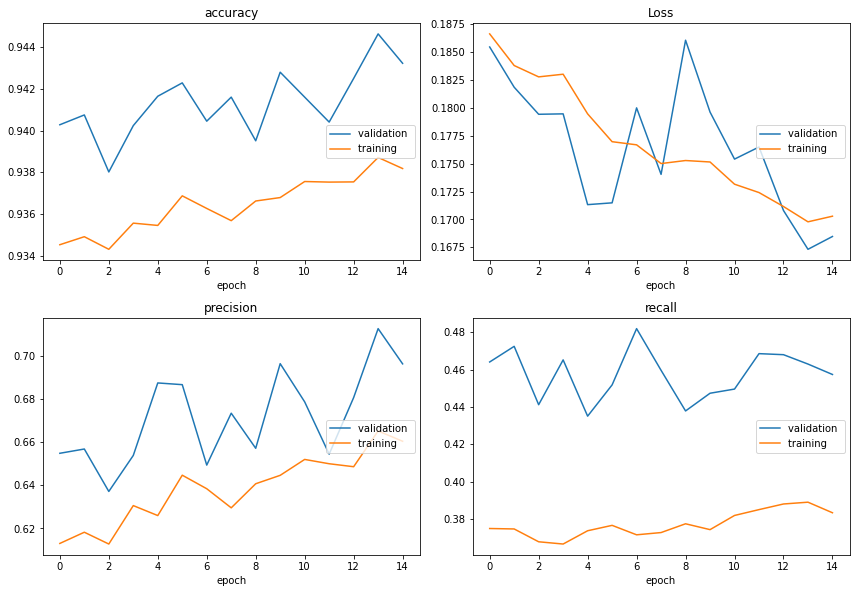

accuracy
	validation       	 (min:    0.938, max:    0.945, cur:    0.943)
	training         	 (min:    0.934, max:    0.939, cur:    0.938)
Loss
	validation       	 (min:    0.167, max:    0.186, cur:    0.168)
	training         	 (min:    0.170, max:    0.187, cur:    0.170)
precision
	validation       	 (min:    0.637, max:    0.713, cur:    0.696)
	training         	 (min:    0.613, max:    0.665, cur:    0.660)
recall
	validation       	 (min:    0.435, max:    0.482, cur:    0.457)
	training         	 (min:    0.367, max:    0.389, cur:    0.383)


In [ ]:
for layer in model.layers:
    layer.trainable = True  # unfreeze
    if hasattr(layer, 'kernel_regularizer'):  # add L2 regularization
            layer.kernel_regularizer = l2(1e-1)

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=epochs//5, mode='min')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=[PlotLossesKeras(), early_stopping], verbose=1, validation_data=(X_val, y_val))

In [ ]:
model.save(os.path.join(weights_folder, "VGG_finetune.h5"))

In [ ]:
model = get_our_VGG_model(False)
model.load_weights(os.path.join(weights_folder, "VGG_finetune.h5"))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 8192)              32768     
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              33558528  
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 4096)             

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc * 100))
print('Loss:          {:.2f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec * 100))
print('Recall:        {:.2f}%'.format(test_rec * 100))

print("")
# Print out the classification metrics per label for Training data
preds = np.round(model.predict(X_test), 0)
classification_metrics = metrics.classification_report(y_test, preds, target_names=encoder.classes_)
print(classification_metrics)

print("")
print("mAP: {:.2f}%".format(average_precision_score(y_test, preds) * 100))


Performance Metrics on Test Set
Accuracy:      94.31%
Loss:          0.18
Precision:     69.81%
Recall:        45.59%

              precision    recall  f1-score   support

   aeroplane       0.92      0.48      0.63        73
     bicycle       0.53      0.40      0.46        65
        bird       0.62      0.45      0.52        80
        boat       0.63      0.54      0.58        57
      bottle       0.34      0.13      0.19        77
         bus       0.72      0.66      0.69        47
         car       0.73      0.38      0.50       121
         cat       0.79      0.45      0.57        92
       chair       0.65      0.39      0.48       124
         cow       0.67      0.14      0.23        29
 diningtable       0.40      0.18      0.24        57
         dog       0.77      0.38      0.51        94
       horse       0.56      0.34      0.42        44
   motorbike       0.71      0.29      0.41        59
      person       0.76      0.70      0.73       498
 pottedplant   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We also tried to use class weighting (class_weights = ... in model.fit) with weights with weights inversely proportional to the data distribution, as well as binary focal loss (using an [implementation from Umberto Griffo](https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py)) to try to improve performance by tackling the unbalancedness of the data), but this did not help. The latter did slightly increase the precision, but at the expense of accuracy and recall. The resulting mAP was significantly lower at about 20%.

### Xception

Instead of VGG16 we can also use other (somewhat) more recent networks such as [Xception](https://arxiv.org/pdf/1610.02357.pdf) from 2017. It should slightly outperform VGG16 (assuming the [results on ImageNet](https://keras.io/applications/#documentation-for-individual-models) carry over here). Indeed, we will see it does, although we had to add an extra classification layer to achieve this. For the rest our methodology is the same as for VGG16.

In [ ]:
def get_our_Xception_model(freeze_non_top):
    xception_without_top = keras.applications.xception.Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet', classes=nb_classes)
    if freeze_non_top:
        for layer in xception_without_top.layers:
            layer.trainable = False

    model = Sequential()
    model.add(xception_without_top)

    model.add(GlobalAveragePooling2D(name='avg_pool'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='sigmoid', name='dense')) # Not in Xception (neither are the dropouts)
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='sigmoid', name='predictions'))

    model.summary()
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])
    return model

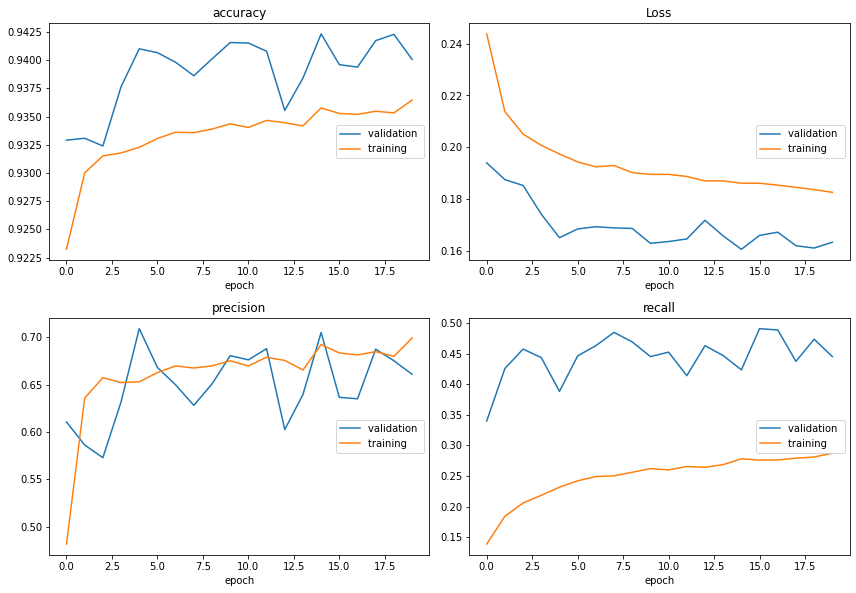

accuracy
	validation       	 (min:    0.932, max:    0.942, cur:    0.940)
	training         	 (min:    0.923, max:    0.936, cur:    0.936)
Loss
	validation       	 (min:    0.161, max:    0.194, cur:    0.163)
	training         	 (min:    0.183, max:    0.244, cur:    0.183)
precision
	validation       	 (min:    0.573, max:    0.709, cur:    0.661)
	training         	 (min:    0.482, max:    0.699, cur:    0.699)
recall
	validation       	 (min:    0.340, max:    0.491, cur:    0.445)
	training         	 (min:    0.139, max:    0.287, cur:    0.287)


In [ ]:
model = get_our_Xception_model(True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=epochs//5, mode='min')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=[PlotLossesKeras(), early_stopping], verbose=1, validation_data=(X_val, y_val))

In [ ]:
model.save(os.path.join(weights_folder, "Xception.h5"))

In [ ]:
model = get_our_Xception_model(True)
model.load_weights(os.path.join(weights_folder, "Xception.h5"))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                20500     
Total params: 22,980,156
Trainable params: 2,118,676
Non-trainable params: 20,861,480
__________________________________

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc * 100))
print('Loss:          {:.2f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec * 100))
print('Recall:        {:.2f}%'.format(test_rec * 100))

print("")
# Print out the classification metrics per label for Training data
preds = np.round(model.predict(X_test), 0)
classification_metrics = metrics.classification_report(y_test, preds, target_names=encoder.classes_)
print(classification_metrics)

print("")
print("mAP: {:.2f}%".format(average_precision_score(y_test, preds) * 100))


Performance Metrics on Test Set
Accuracy:      94.22%
Loss:          0.16
Precision:     67.90%
Recall:        46.86%

              precision    recall  f1-score   support

   aeroplane       0.90      0.48      0.62        73
     bicycle       0.86      0.28      0.42        65
        bird       1.00      0.11      0.20        80
        boat       0.78      0.12      0.21        57
      bottle       0.43      0.04      0.07        77
         bus       0.58      0.81      0.67        47
         car       0.70      0.51      0.59       121
         cat       0.94      0.49      0.64        92
       chair       0.63      0.21      0.32       124
         cow       1.00      0.14      0.24        29
 diningtable       0.58      0.19      0.29        57
         dog       0.74      0.39      0.51        94
       horse       0.87      0.30      0.44        44
   motorbike       0.59      0.61      0.60        59
      person       0.63      0.83      0.71       498
 pottedplant   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Next we again finetune the model.

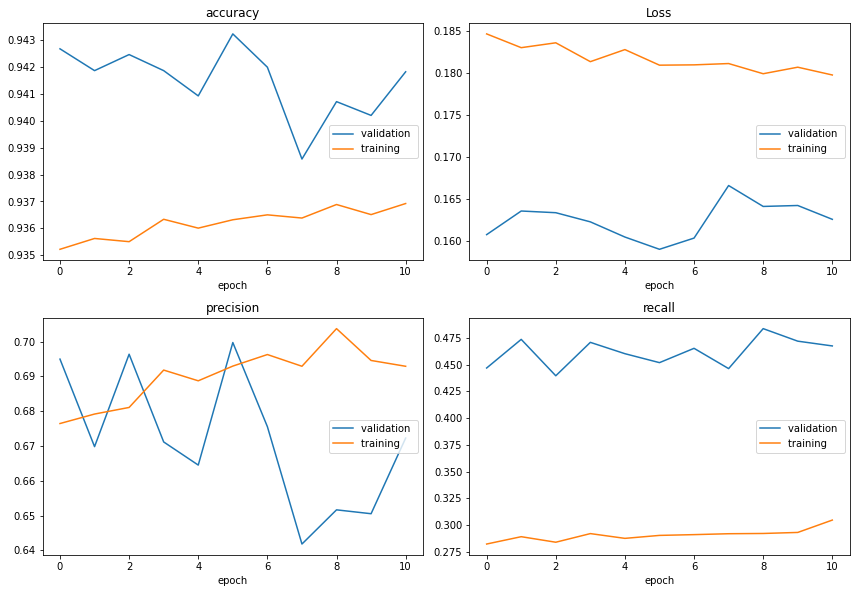

accuracy
	validation       	 (min:    0.939, max:    0.943, cur:    0.942)
	training         	 (min:    0.935, max:    0.937, cur:    0.937)
Loss
	validation       	 (min:    0.159, max:    0.167, cur:    0.163)
	training         	 (min:    0.180, max:    0.185, cur:    0.180)
precision
	validation       	 (min:    0.642, max:    0.700, cur:    0.672)
	training         	 (min:    0.676, max:    0.704, cur:    0.693)
recall
	validation       	 (min:    0.440, max:    0.484, cur:    0.467)
	training         	 (min:    0.282, max:    0.305, cur:    0.305)


In [ ]:
for layer in model.layers:
    layer.trainable = True  # unfreeze
    if hasattr(layer, 'kernel_regularizer'):  # add L2 regularization
            layer.kernel_regularizer = l2(1e-1)

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=epochs//5, mode='min')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=[PlotLossesKeras(), early_stopping], verbose=1, validation_data=(X_val, y_val))

In [ ]:
model.save(os.path.join(weights_folder, "Xception_finetune.h5"))

A note about the loading below: we do not re-unfreeze the lower layers. This is not important as we will not train the loaded model any further.

In [ ]:
model = get_our_Xception_model(True) # Does not work with False for some reason
model.load_weights(os.path.join(weights_folder, "Xception_finetune.h5"))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                20500     
Total params: 22,980,156
Trainable params: 2,118,676
Non-trainable params: 20,861,480
__________________________________

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc * 100))
print('Loss:          {:.2f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec * 100))
print('Recall:        {:.2f}%'.format(test_rec * 100))

print("")
# Print out the classification metrics per label for Training data
preds = np.round(model.predict(X_test), 0)
classification_metrics = metrics.classification_report(y_test, preds, target_names=encoder.classes_)
print(classification_metrics)

print("")
print("mAP: {:.2f}%".format(average_precision_score(y_test, preds) * 100))


Performance Metrics on Test Set
Accuracy:      94.22%
Loss:          0.16
Precision:     67.18%
Recall:        48.31%

              precision    recall  f1-score   support

   aeroplane       0.88      0.41      0.56        73
     bicycle       0.71      0.31      0.43        65
        bird       1.00      0.19      0.32        80
        boat       0.80      0.14      0.24        57
      bottle       0.58      0.19      0.29        77
         bus       0.71      0.74      0.73        47
         car       0.64      0.56      0.60       121
         cat       0.92      0.51      0.66        92
       chair       0.61      0.27      0.37       124
         cow       1.00      0.10      0.19        29
 diningtable       0.43      0.51      0.46        57
         dog       0.79      0.29      0.42        94
       horse       0.93      0.30      0.45        44
   motorbike       0.63      0.63      0.63        59
      person       0.64      0.82      0.72       498
 pottedplant   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see that the mAP has improved slightly, but is still only at around 30%. To get a feeling of what this means qualitatively, we show images together with our model's predictions. More specifically we'll present the classes with confidence at least 0.5, as well as that confidence. The second cell below can be run multiple times to get different images. Note that if our model predicts that the image contains none of the 20 classes, the image will have no label (title).

In [ ]:
random_indices = list(range(len(X_test)))
random.shuffle(random_indices)
random_indices_iter = iter(random_indices)

In [ ]:
def y_preds_to_list_of_labels_with_confidence(y_preds):
    y_preds_bin = np.round(y_preds, 0)
    y_pred_labels = encoder.inverse_transform(y_preds_bin)

    y_pred_labels_with_conf = []
    for j in range(len(y_pred_labels)):
        img_labels = y_pred_labels[j]
        img_labels_with_conf = []
        for label in img_labels:
            img_labels_with_conf.append(label + " ({:.2f})".format(y_preds[j][get_index_of_object(label)]))
        y_pred_labels_with_conf.append(img_labels_with_conf)
    
    return y_pred_labels_with_conf

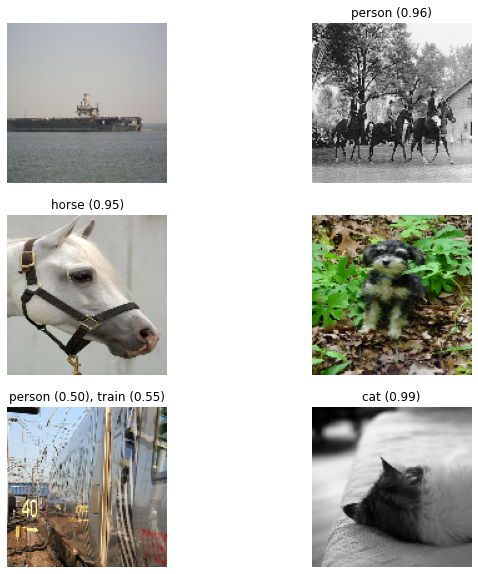

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 3

next_is = []  # (the 's' is for plural)
for j in range(columns * rows):
    next_is.append(next(random_indices_iter))

xs = []
for i in next_is:
    xs.append(X_test[i])

y_preds = model.predict(np.array(xs))
y_preds_labels_conf = y_preds_to_list_of_labels_with_confidence(y_preds)

for j in range(columns * rows):
    img = cv2.cvtColor(xs[j], cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(img)
    plt.title(list_of_strings_to_string(y_preds_labels_conf[j]))
    plt.axis('off')
    
plt.show()

To link these qualitative results back to the quantitative metrics of precision and recall, let us consider the class "person". Since the precision for "person" is pretty high, if an image contains a person this is mostly detected. Since the recall is also pretty high, if the model predicts that an image contains a person, than it is likely that this is indeed the case. But neither one of these metrics is at (or close to) 100%, so we will regularly make mistakes concerning people.

##IV. Adversarial noise

We will now want try to 'break' our classifier. The idea is that given an input image we will cleverly generate some noise that when added to the original input causes the classifier to confuse classes. Since it is not obvious how to do this (excluding direct gradient based methods such as the fast gradient sign method [(Goodfellow et al., 2015)](https://arxiv.org/pdf/1412.6572.pdf)), we'll train a model to generate this noise.

Preferably we would use our finetuned Xception model, but unfortunately Keras seems to have [issues with freezing BatchNormalization](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/) (and potentially also Dropout) layers, which causes us to experience situations where according to the training progress we where performing great (precision and recall at around 1), but when evaluating on the _training_ set, we got horrendous results (precision and recall at 0). Therefore, we will quickly train our VGG16 model, but now without dropout and batch normalization.

In [ ]:
def get_our_VGG_model_no_dropout_or_batchnorm(freeze_non_top):
    vgg_without_top = VGG16(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
    if freeze_non_top:
        for layer in vgg_without_top.layers:
            layer.trainable = False

    model = Sequential()
    model.add(vgg_without_top)

    model.add(Flatten())
    model.add(Dense(4096, activation='relu', name='fc1'))
    model.add(Dense(4096, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation='sigmoid', name='prediction'))

    model.summary()
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model

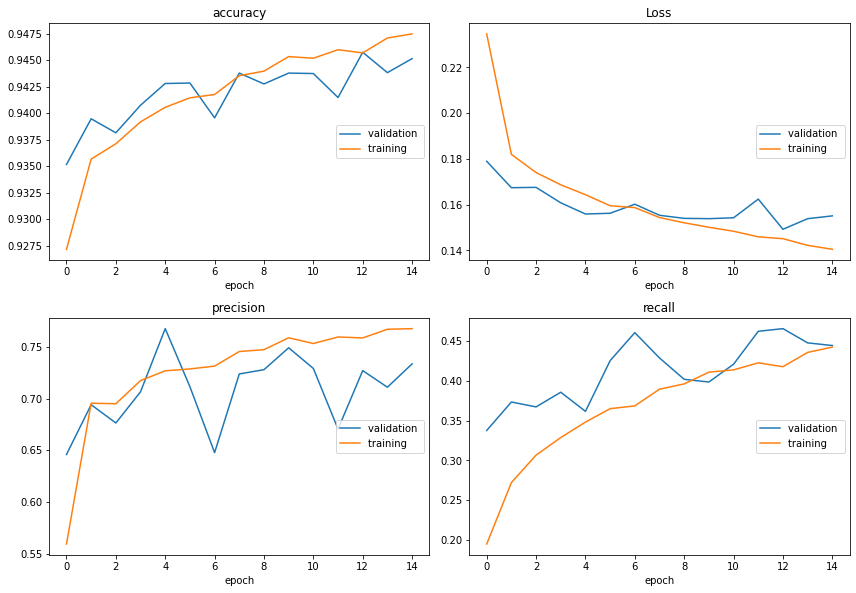

accuracy
	validation       	 (min:    0.935, max:    0.946, cur:    0.945)
	training         	 (min:    0.927, max:    0.947, cur:    0.947)
Loss
	validation       	 (min:    0.149, max:    0.179, cur:    0.155)
	training         	 (min:    0.141, max:    0.235, cur:    0.141)
precision
	validation       	 (min:    0.646, max:    0.768, cur:    0.734)
	training         	 (min:    0.559, max:    0.768, cur:    0.768)
recall
	validation       	 (min:    0.338, max:    0.465, cur:    0.444)
	training         	 (min:    0.195, max:    0.442, cur:    0.442)


In [ ]:
batch_size = 32
epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=epochs//5, mode='min')

model = get_our_VGG_model_no_dropout_or_batchnorm(True)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=[PlotLossesKeras(), early_stopping], verbose=1, validation_data=(X_val, y_val))

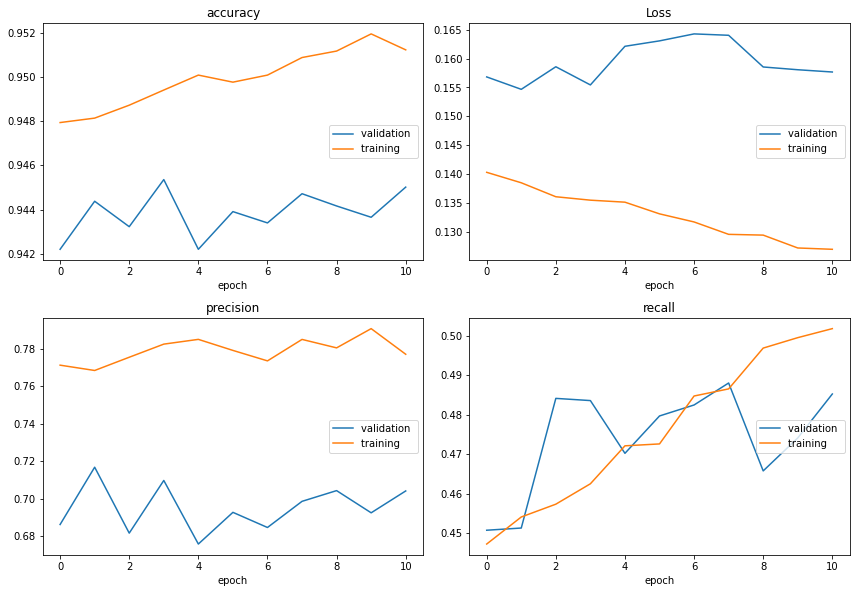

accuracy
	validation       	 (min:    0.942, max:    0.945, cur:    0.945)
	training         	 (min:    0.948, max:    0.952, cur:    0.951)
Loss
	validation       	 (min:    0.155, max:    0.164, cur:    0.158)
	training         	 (min:    0.127, max:    0.140, cur:    0.127)
precision
	validation       	 (min:    0.676, max:    0.717, cur:    0.704)
	training         	 (min:    0.769, max:    0.791, cur:    0.777)
recall
	validation       	 (min:    0.451, max:    0.488, cur:    0.485)
	training         	 (min:    0.447, max:    0.502, cur:    0.502)


In [ ]:
for layer in model.layers:
    layer.trainable = True
    if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer = l2(1e-1)

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                    callbacks=[PlotLossesKeras(), early_stopping], verbose=1, validation_data=(X_val, y_val))

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=2)
print('')
print('Performance Metrics on Test Set')
print('Accuracy:      {:.2f}%'.format(test_acc * 100))
print('Loss:          {:.2f}'.format(test_loss))
print('Precision:     {:.2f}%'.format(test_prec * 100))
print('Recall:        {:.2f}%'.format(test_rec * 100))

print("")
preds = np.round(model.predict(X_test), 0)
classification_metrics = metrics.classification_report(y_test, preds, target_names=encoder.classes_)
print(classification_metrics)

print("")
print("mAP: {:.2f}%".format(average_precision_score(y_test, preds) * 100))


Performance Metrics on Test Set
Accuracy:      94.43%
Loss:          0.16
Precision:     70.41%
Recall:        47.31%

              precision    recall  f1-score   support

   aeroplane       1.00      0.47      0.64        73
     bicycle       0.44      0.49      0.46        65
        bird       0.75      0.60      0.67        80
        boat       0.58      0.39      0.46        57
      bottle       0.62      0.13      0.22        77
         bus       0.77      0.64      0.70        47
         car       0.80      0.31      0.44       121
         cat       0.73      0.43      0.54        92
       chair       0.70      0.37      0.48       124
         cow       0.50      0.31      0.38        29
 diningtable       0.42      0.30      0.35        57
         dog       0.79      0.47      0.59        94
       horse       0.59      0.39      0.47        44
   motorbike       0.66      0.32      0.43        59
      person       0.77      0.72      0.75       498
 pottedplant   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Removing the dropout and batch normalization layers did not significantly decrease the performance

In [ ]:
model.save(os.path.join(weights_folder, "VGG_no_dropout_or_batchnorm_finetune.h5"))

In case you want to reload this model you can use the following code (not necessary when running the notebook in its entirety).

In [ ]:
model = get_our_VGG_model_no_dropout_or_batchnorm(False)
model.load_weights(os.path.join(weights_folder, "VGG_no_dropout_or_batchnorm_finetune.h5"))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              33558528  
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
prediction (Dense)           (None, 20)                81940     
Total params: 65,136,468
Trainable params: 65,136,468
Non-trainable params: 0
_________________________________________________________________


We now freeze its weights as we want to fool this model, not some variant with slightly different updated weights.

In [ ]:
classification_model = model
for layer in classification_model.layers:
    layer.trainable = False

Let's make noise so that aeroplanes are classified as cats. These classes are not chosen completely randomly. Indeed, we want the deceptive class (cat) to have good (or at least not absolutely horrible) recall for the classifier. Imagine that this would not be the case and that our classifier actually never predicts this class. Then it would be impossible to generate noise (or any image in general) which is recognized as a cat, meaning in particular that our model can not be deceived to recognize cats whatsoever.
The class 'aeroplane' was chosen as it has somewhat decent precision. To reason is that it makes little sense to say the classifier is deceived by our noise if it would not even have been correct without noise.

To achieve this deception we will take all images containing aeroplanes and label them such that they officially contains cats instead of aeroplanes.

In [ ]:
aeroplane_index = get_index_of_object("aeroplane")
X_train_aeroplane = np.array([X_train[i] for i in range(len(y_val)) if y_train[i][aeroplane_index] == 1])
y_train_aeroplane = np.array([y_train[i] for i in range(len(y_val)) if y_train[i][aeroplane_index] == 1])

y_train_aeroplane_cat = y_train_aeroplane.copy()
cat_index = get_index_of_object("cat")
for i in range(len(y_train_aeroplane)):
    y_train_aeroplane_cat[i][aeroplane_index] = 0 # no aeroplane
    y_train_aeroplane_cat[i][cat_index] = 1 # but a cat

Below we give an example of these deceptive labels. The second cell can be run repeatedly to show different images.

In [ ]:
i = 50

[('cat',)]


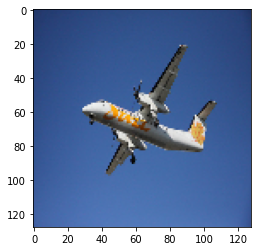

In [ ]:
plt.imshow(cv2.cvtColor(X_train_aeroplane[i], cv2.COLOR_BGR2RGB))
print(encoder.inverse_transform(np.array([y_train_aeroplane_cat[i]])))
i += 1

Now we define our model which generates the adversarial noise. Since the output needs to be an image of the same size as the input, we have opted for a UNet type architecture. For the encoder we use MobileNetV2. We have also tried ResNet34, but this gave worse results.

Because we want the noise to be additive, which for a normalized image has components in $[-1, 1]$, we use $\tanh$ as final activation.

In [ ]:
adversarial_model = sm.Unet('mobilenetv2', classes=3, encoder_weights='imagenet', activation='tanh', input_shape=(img_size, img_size, 3))  # tanh to allow for (bounded) negative output
adversarial_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_____________________________

Now for the most important question: how do we train this adversarial model? Our goal is that it generates additive noise so that the noisy images are incorrectly predicted. Therefore, we will judge it for this capability. This means we will make a combined network composed of the adversarial model and the classifier. Since we know what we want for the output of this combined model, we can just employ classical supervised learning with our deceptive labels.

More concretely, given a (batch of) input image(s), we compute the output and the loss with respect to the deceptive labels. We then do backpropagation across the entire combined network to get gradients for the adversarial network's weights. (Since we don't want to update the classifier's weights, those gradients are ignored.) This means that in particular we need to propagate the gradient through the classifier. When we know the weights of the classifier this is easy to do analytically. (In principle we can also (approximately) compute the gradient of any (black-box) function using finite differences, but this is vastly less efficient.) Therefore, this adversarial attack is white-box.

Finally, ideally our noise would be almost imperceptible (of course if we create noise which literally transforms an image of an aeroplane into an image of a cat, we can't blame our classifier for predicting cat). Therefore we add L2-regularization on the output of the adversarial model.

In [ ]:
inputs = keras.layers.Input(shape=(img_size, img_size, 3))
delta = adversarial_model(inputs)
delta = ActivityRegularization(l2=1e-3)(delta)  # Keep delta small
input_plus_delta = keras.layers.Add()([inputs, delta])
outputs = classification_model(input_plus_delta)
combined_model = keras.Model(inputs=inputs, outputs=outputs)

We could now compile this combined_model with binary crossentropy loss and train using Model.fit and X_train_aeroplane, y_train_aeroplane_cat as training data (we need no validation set as we can't really overfit since we don't need to generalize). Unfortunately this approach does not work and we will never predict cats. Therefore we only focus on aeroplane and cat at the moment, and ignore all the other classes. 

By adding a well-chosen dense layer we can extract the classifier's prediction for the classes of aeroplane and cat.

In [ ]:
aeroplane_cat_outputs = Dense(2, use_bias=False)(outputs)
combined_model_aeroplane_cat = keras.Model(input=inputs, outputs=aeroplane_cat_outputs)
aeroplane_cat_dense_weights = np.zeros((nb_classes, 2), dtype='float')
aeroplane_cat_dense_weights[aeroplane_index, 0] = 1
aeroplane_cat_dense_weights[cat_index, 1] = 1
combined_model_aeroplane_cat.layers[-1].set_weights([aeroplane_cat_dense_weights]) 
combined_model_aeroplane_cat.layers[-1].trainable = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


We will now train with only the labels of aeroplane and cat. Since our training set by definition only has pictures of aeroplanes, which we classify as cats, this means that on the training set we want to always predict 0 (no) for aeroplane and 1 (yes) for cat. Without the risk of overfitting we need not worry about training for too long. And since we use a much smaller data set this is computationally feasible.

In [ ]:
combined_model_aeroplane_cat.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])
combined_model_aeroplane_cat.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 3)  8047731     input_10[0][0]                   
__________________________________________________________________________________________________
activity_regularization_1 (Acti (None, 128, 128, 3)  0           model_1[1][0]                    
__________________________________________________________________________________________________
add_37 (Add)                    (None, 128, 128, 3)  0           input_10[0][0]                   
                                                                 activity_regularization_1[0

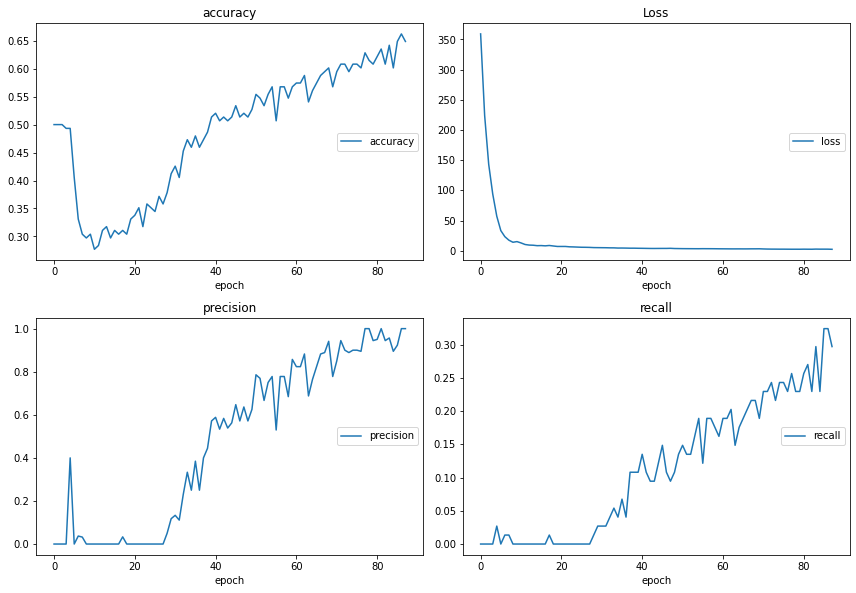

accuracy
	accuracy         	 (min:    0.277, max:    0.662, cur:    0.649)
Loss
	loss             	 (min:    2.315, max:  359.208, cur:    2.315)
precision
	precision        	 (min:    0.000, max:    1.000, cur:    1.000)
recall
	recall           	 (min:    0.000, max:    0.324, cur:    0.297)
Epoch 89/1000


In [ ]:
batch_size = 32
epochs = 1000

combined_model_aeroplane_cat.fit(X_train_aeroplane, np.array([[0, 1]] * len(X_train_aeroplane)), batch_size=batch_size, epochs=epochs,
                             callbacks=[PlotLossesKeras()], verbose=1)

In [ ]:
adversarial_model.save(os.path.join(weights_folder, "adversarial_mobilenetv2_imagenet.h5"))

In [ ]:
adversarial_model = sm.Unet('mobilenetv2', classes=3, encoder_weights='imagenet', activation='tanh', input_shape=(img_size, img_size, 3))
adversarial_model.load_weights(os.path.join(weights_folder, "adversarial_mobilenetv2_imagenet.h5"))

To qualitatively evaluate our adversarial model's performance we use the two cells below. The second one can be run repeatedly to get different input images.

In [ ]:
random_indices = list(range(len(X_train_aeroplane)))
random.shuffle(random_indices)
random_indices_iter = iter(random_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classifier prediction with noise: aeroplane (0.51), person (0.66)
Classifier prediction without noise: aeroplane (0.73), car (0.51)
True labels: aeroplane (1.00), car (1.00)
Deceptive labels: car (1.00), cat (1.00)


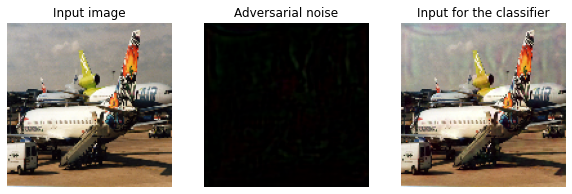

In [ ]:
fig=plt.figure(figsize=(10, 10))

i = next(random_indices_iter)
x = X_train_aeroplane[i]
delta = adversarial_model.predict(np.array([x]))[0]
x_plus_delta = x + delta

img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 1)
plt.imshow(img)
plt.title("Input image")
plt.axis('off')

img = cv2.cvtColor(delta, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 2)
plt.imshow(img)
plt.title("Adversarial noise")
plt.axis('off')

img = cv2.cvtColor(x_plus_delta, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 3)
plt.imshow(img)
plt.title("Input for the classifier")
plt.axis('off')

y_pred_clean = classification_model.predict(np.array([x]))
y_pred_noise = classification_model.predict(np.array([x_plus_delta]))
print("Classifier prediction with noise: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(y_pred_noise)[0])))
print("Classifier prediction without noise: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(y_pred_clean)[0])))
print("True labels: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(np.array([y_train_aeroplane[i]]))[0])))
print("Deceptive labels: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(np.array([y_train_aeroplane_cat[i]]))[0])))

The added noise is most of the time not too distracting for us humans. But it does sometimes make the classifier predict cat instead of aeroplane.

At this point we could now train our combined model further with all training data and all labels (but with aeroplanes changed into cats). But although this does increase precision and recall, we found that it comes at the expense of predicting cats. Therefore we do not do it here.

In [ ]:
train = []
for i in range(len(X_train_aeroplane)):
  x = X_train_aeroplane[i]
  delta = adversarial_model.predict(np.array([x]))[0]
  euclid_dist = np.sum((delta)**2)
  train.append(euclid_dist)

l2Train = np.average(train)

Performance on test set:

In [ ]:
X_test_aeroplane = np.array([X_test[i] for i in range(len(y_val)) if y_test[i][aeroplane_index] == 1])
y_test_aeroplane = np.array([y_test[i] for i in range(len(y_val)) if y_test[i][aeroplane_index] == 1])

y_test_aeroplane_cat = y_test_aeroplane.copy()
cat_index = get_index_of_object("cat")
for i in range(len(y_test_aeroplane)):
    y_test_aeroplane_cat[i][aeroplane_index] = 0 # no aeroplane
    y_test_aeroplane_cat[i][cat_index] = 1 # but a cat

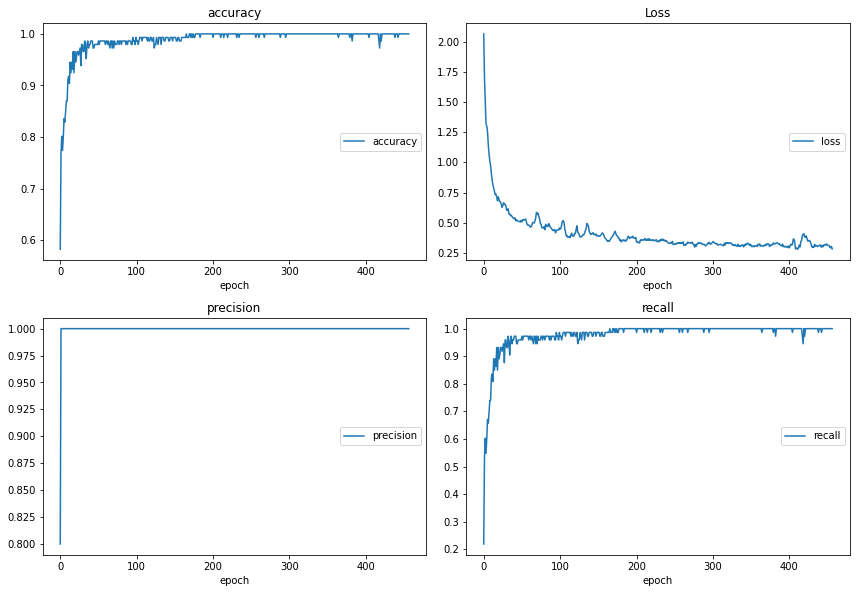

accuracy
	accuracy         	 (min:    0.582, max:    1.000, cur:    1.000)
Loss
	loss             	 (min:    0.280, max:    2.065, cur:    0.284)
precision
	precision        	 (min:    0.800, max:    1.000, cur:    1.000)
recall
	recall           	 (min:    0.219, max:    1.000, cur:    1.000)
Epoch 458/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.2974 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


In [ ]:
batch_size = 32
epochs = 1000

combined_model_aeroplane_cat.fit(X_test_aeroplane, np.array([[0, 1]] * len(X_test_aeroplane)), batch_size=batch_size, epochs=epochs,
                             callbacks=[PlotLossesKeras()], verbose=1)

In [ ]:
adversarial_model.save(os.path.join(weights_folder, "adversarial_mobilenetv2_imagenet_test.h5"))

In [ ]:
adversarial_model = sm.Unet('mobilenetv2', classes=3, encoder_weights='imagenet', activation='tanh', input_shape=(img_size, img_size, 3))
adversarial_model.load_weights(os.path.join(weights_folder, "adversarial_mobilenetv2_imagenet_test.h5"))

In [ ]:
random_indices = list(range(len(X_test_aeroplane)))
random.shuffle(random_indices)
random_indices_iter = iter(random_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classifier prediction with noise: bird (0.59)
Classifier prediction without noise: aeroplane (1.00)
True labels: aeroplane (1.00)
Deceptive labels: cat (1.00)


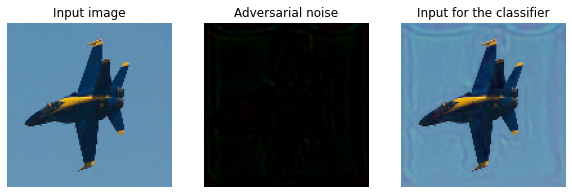

In [ ]:
fig=plt.figure(figsize=(10, 10))

i = next(random_indices_iter)
x = X_test_aeroplane[i]
delta_test = adversarial_model.predict(np.array([x]))[0]
x_plus_delta = x + delta_test

img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 1)
plt.imshow(img)
plt.title("Input image")
plt.axis('off')

img = cv2.cvtColor(delta_test, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 2)
plt.imshow(img)
plt.title("Adversarial noise")
plt.axis('off')

img = cv2.cvtColor(x_plus_delta, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 3)
plt.imshow(img)
plt.title("Input for the classifier")
plt.axis('off')

y_pred_clean = classification_model.predict(np.array([x]))
y_pred_noise = classification_model.predict(np.array([x_plus_delta]))
print("Classifier prediction with noise: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(y_pred_noise)[0])))
print("Classifier prediction without noise: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(y_pred_clean)[0])))
print("True labels: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(np.array([y_test_aeroplane[i]]))[0])))
print("Deceptive labels: {}".format(list_of_strings_to_string(y_preds_to_list_of_labels_with_confidence(np.array([y_test_aeroplane_cat[i]]))[0])))

We comparise the amount of noise needed between for our train set and test set. Our hypothesis is that less noise is needed for the test set, as performance is already lower there. To quantify this we use the average L2-norm of the generated noise.

In [ ]:
test = []
for i in range(len(X_test_aeroplane)):
  x = X_test_aeroplane[i]
  delta_test = adversarial_model.predict(np.array([x]))[0]
  euclid_dist = np.sum((delta_test)**2)
  test.append(euclid_dist)

l2Test = np.average(test)

In [ ]:

print("Average L2-norm on the training set: {}".format(l2Train))
print("Average L2-norm on the test set: {}".format(l2Test))

Average L2-norm on the training set: 10.858927726745605
Average L2-norm on the test set: 10.567015647888184


As we can see, our hypothesis holds.

This part can be run completely independently from the first.

##V. Final Discussion

##**Classification**

For the classification, we started by defining a from-scratch ConvNet architecture for image classification, based on models that have proven to be working well for similar kinds of problems. We use intensive hyperparameter tuning to improve the performance of the classifier. Our main take-aways are that dropout and data augmentation help to avoid overfitting, batch normalization speeds up training, and a smaller model architecture with ~5M parameters performs better compared to larger architectures with ~10M or 20M parameters. The best results reached on the test set were an accuracy of 94%, loss of 0.168 and mAP of 25.5%. 

Next, we trained a second model using adversarial training. In theory, this model should generalize better compared to the first model, however some more hyperparameter tuning effort is required to achieve lower Loss.

We continued by training two transfer learning models, using VGG16 and Xception architectures and starting from ImageNet weights. We are expecting that those models will achieve significantly better performance compared to the from-scratch model, as they have been trained on large datasets with more than a million of images (and thousands of classes), therefore they are able to generalize well in a wide range of settings, especially after finetuning them. The results achieved on the test set were for VGG16: accuracy 93.3%, loss 0.18, mAP 29.2%, and for Xception: accuracy 94.2%, loss 0.16, mAP: 31.29%.

As it was expected, the transfer learning models have superior performance compared to the from-scratch model. Apart from accuracy and loss, we give more emphasis to the mean Average Precision measure, as it is the most appropriate metric for this kind of problem. Xception yields the highest mAP, 31.29%, 5.8 points more vs the from-scratch model.


##**Adversarial noise**

We then added a network to generate noise in order to fool our classifiers into thinking aeroplanes are cats. Because of issues with batch normalization and dropout we were forced to retrain our VGG16 model without these layers. 
We were quite successful in generating such adversarial noise, although it should be noted be only wanted to generate noise on select sets of images, without a strong need for generalization.

We were indeed able to fool our network. When training on the classifier's test set we needed smaller perturbations compared to on the classifier's training set.

One might now wonder if this makes our classifiers useless. We argue it depends on the application domain. Adversarial noise does not occur in real life, so as long as we are the ones using the classifier, we need not worry. But if it is integrated into a larger system, automatically processing inputs, then we should be mindful of the possible security risks.

##**Improvements**

- To improve the performance of the classification models, we can certainly experiemnt with different architecture. For the scratch model, we can experiment with more layers, more filters in each layer, different dropout values, adding regularization etc. For the transfer learning part, we could test different model architectures, such as GoogLeNet, ResNet, MobileNetV2 etc. 

- We could also implement more intensive hyperparameter tuning in all our models. Running large experiements testing combinations of several architectural choices, or smaller experiments for different values of a handful of hyperparameters could yield improvements on the performance of our models. However, this process requires lots of time and computational power. 

- Moreover, the performance can be improved by using an ensemble of the models that we trained for the classification and selmentation task. For example, we could build an ensemble of the scratch model, the VGG model and the Xception model for classification, using the weights that we have saved, so the 3 models have an equal vote on the predictions. Experience has shown that ensemble models improve the performance, as each model learns different features/weights and their combination gives better results.

- One alternative to transfer learning for our segmentation model could have been to use our trained classifier as encoder part of the Unet. Time did not allow us to check if this option was valid and if the classifier architecture could easily fit into a Unet (especially for the skip connections) or needed significant modifications to do so.  

- Obviously we are disappointed that we could not use the adversarial attack on our best performing classifier built on the Xception architecture. This would have posed a more interesting test. Given more time we should look into ways of tackling the issues with freezing batch normalization layers. Perhaps moving to another API such as PyTorch might be the best strategy. 